# Определяем перспективный тариф для телеком-компании «Мегалайн»

In [242]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [243]:
# seaborn theme
custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'font.sans-serif': ['Helvetica',
                                     'Verdana',
                                     'sans-serif']
                 }
sns.set_theme(style="ticks", rc=custom_params)

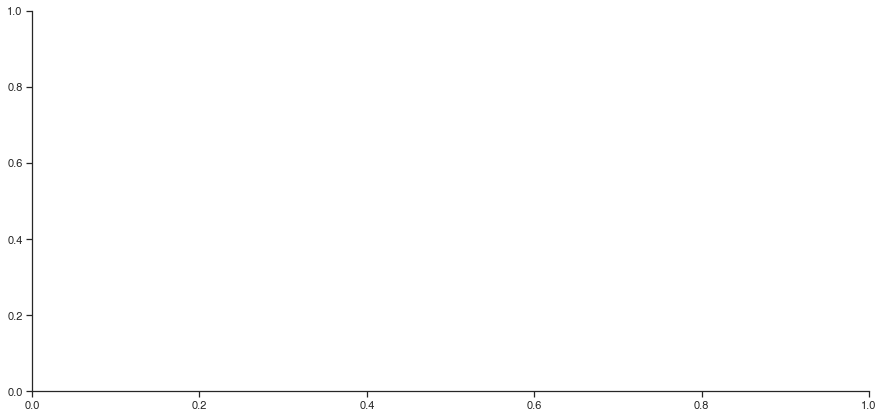

In [248]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(15, 7))

In [106]:
mb_in_gb = 1024

<div class="alert alert-info" role="alert">
    <p class="mb-0">В коде использую <code>display()</code>, потомучто это однозначно даёт понять что планируется вывод / печать результатов. То есть использую <code>display()</code> намеренно, хотя понимаю что можно и без него выводить данные. 👌</p>
</div>

## Шаг 0. Введение

В этом учебном проекте сделаем предварительный анализ тарифов на выборке данных 500 пользователей «Мегалайна». Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

<hr>

## Шаг 1. Знакомимся с данными изучаем общую информацию

Откройте файл с данными и изучите общую информацию

In [107]:
calls_df = pd.read_csv('./datasets/calls.csv')
internet_df = pd.read_csv('./datasets/internet.csv', index_col=0)
messages_df = pd.read_csv('./datasets/messages.csv')
tariffs_df = pd.read_csv('./datasets/tariffs.csv')
users_df = pd.read_csv('./datasets/users.csv')

### Описание данных

#### Таблица calls (информация о звонках):
`id` — уникальный номер звонка
`call_date` — дата звонка
`duration` — длительность звонка в минутах
`user_id` — идентификатор пользователя, сделавшего звонок

In [108]:
display(
    calls_df.info(),
    calls_df.sample(3)
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
156800,1387_20,2018-12-24,0.00,1387
163181,1402_4,2018-12-16,10.02,1402
41805,1102_232,2018-06-18,19.37,1102


#### Таблица internet (информация об интернет-сессиях):
`id` — уникальный номер сессии
`mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
`session_date` — дата интернет-сессии
`user_id` — идентификатор пользователя

In [109]:
display(
    internet_df.info(),
    internet_df.sample(3),
    # len(list(internet_df['id'].unique()))
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


None

,id,mb_used,session_date,user_id
29374,1102_248,0.00,2018-07-10,1102
98165,1330_373,326.94,2018-04-21,1330
23448,1079_51,650.20,2018-12-09,1079


#### Таблица messages (информация о сообщениях):
`id` — уникальный номер сообщения
`message_date` — дата сообщения
`user_id` — идентификатор пользователя, отправившего сообщение

In [110]:
display(
    messages_df.info(),
    messages_df.sample(3),
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
119434,1483_369,2018-05-11,1483
14292,1062_5,2018-12-04,1062
50635,1226_311,2018-11-23,1226


#### Таблица tariffs (информация о тарифах):
`tariff_name` — название тарифа
`rub_monthly_fee` — ежемесячная абонентская плата в рублях
`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
`messages_included` — количество сообщений в месяц, включённых в абонентскую плату
`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [111]:
display(
    tariffs_df,
    tariffs_df['tariff_name'],
)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


0    smart
1    ultra
Name: tariff_name, dtype: object

#### Таблица users (информация о пользователях):
`user_id` — уникальный идентификатор пользователя
`first_name` — имя пользователя
`last_name` — фамилия пользователя
`age` — возраст пользователя (годы)
`reg_date` — дата подключения тарифа (день, месяц, год)
`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
`city` — город проживания пользователя
`tariff` — название тарифного плана

In [112]:
display(
    users_df.info(),
    users_df.sample(3),
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
248,1248,51,NaN,Москва,Анатолий,Минаев,2018-05-28,smart
458,1458,36,NaN,Барнаул,Роберт,Азаров,2018-02-13,ultra
334,1334,45,NaN,Владивосток,Пётр,Минаев,2018-11-16,smart


<hr>

## Шаг 2. Подготавливаем данные

calls_df

internet_df

messages_df

tariffs_df

In [113]:
users_df

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


calls_df
internet_df
messages_df
tariffs_df
users_df

### U

In [114]:
display(
    users_df.loc[users_df['churn_date'].notna()]
)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart
56,1056,73,2018-10-14,Иркутск,Радислав,Артемьев,2018-04-13,smart
62,1062,24,2018-12-09,Москва,Александр,Коршунов,2018-11-16,smart
63,1063,45,2018-12-11,Тула,Таира,Климова,2018-04-12,ultra
64,1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart
65,1065,53,2018-12-09,Москва,Роза,Игнатова,2018-03-08,smart


### Дубликаты

In [115]:
display(
    calls_df.loc[calls_df.duplicated()].count()
)

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [116]:
display(
    internet_df.loc[internet_df.duplicated()].count()
)

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [117]:
display(
    messages_df.loc[messages_df.duplicated()].count()
)

id              0
message_date    0
user_id         0
dtype: int64

In [118]:
display(
    users_df.loc[users_df.duplicated()].count(),
    users_df['user_id'].value_counts().sum()
)

user_id       0
age           0
churn_date    0
city          0
first_name    0
last_name     0
reg_date      0
tariff        0
dtype: int64

500

### Найдите и исправьте ошибки в данных, если они есть.

In [119]:
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'], errors='coerce', format='%Y-%m-%d')

In [120]:
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'], errors='coerce', format='%Y-%m-%d')

In [121]:
print(
    'columns',
    list(users_df.columns),

    '\nage description',
    users_df['age'].describe(),

    '\nregistration date min → max',
    users_df['reg_date'].min().strftime('%Y-%m-%d'),
    users_df['reg_date'].max().strftime('%Y-%m-%d'),

    '\ncount of unique city',
    len(users_df['city'].unique()),

    '\ncount of unique first name',
    len(users_df['first_name'].unique()),

    '\ncount of unique last name',
    len(users_df['last_name'].unique()),

    '\nunique tariffs',
    users_df['tariff'].unique(),
    sep='\n'
)

columns
['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff']

age description
count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

registration date min → max
2018-01-01
2018-12-31

count of unique city
76

count of unique first name
246

count of unique last name
419

unique tariffs
['ultra' 'smart']


Проверим `'last_name'`, `'first_name'` и `'city'` на пробелы в начале и окончании.

In [122]:
print(
    'first_name →',
    users_df['first_name'].apply(lambda fnm: fnm if ' ' in [fnm[0], fnm[-1]] else np.NaN).count(),
    '\nlast_name →',
    users_df['last_name'].apply(lambda fnm: fnm if ' ' in [fnm[0], fnm[-1]] else np.NaN).count(),
    '\ncity → ',
    users_df['city'].apply(lambda fnm: fnm if ' ' in [fnm[0], fnm[-1]] else np.NaN).count(),
)

first_name → 0 
last_name → 0 
city →  0


Пробелов нет.

#### Поясните, какие ошибки вы нашли и как их исправили.

### Приведите данные к нужным типам;

#### `tariffs_df`

#### `messages_df`

In [123]:
messages_df['message_date'] = pd.to_datetime(
    messages_df['message_date'],
    errors='coerce',
    format='%Y-%m-%d'
)

# messages_df = messages_df.astype(
#     {
#         'user_id': 'uint16',
#         'message_date': 'uint8',
#         # 'churn_date': '',
#         'city': 'category',
#         'first_name': 'category',
#         # 'last_name': '',
#         # 'reg_date': '',
#         'tariff': 'bool',
#     }
# )

#### `internet_df`

In [124]:
internet_df['session_date'] = pd.to_datetime(
    internet_df['session_date'],
    errors='coerce',
    format='%Y-%m-%d'
)

# internet_df = internet_df.astype(
#     {
#         'user_id': 'uint16',
#         'message_date': 'uint8',
#         # 'churn_date': '',
#         'city': 'category',
#         'first_name': 'category',
#         # 'last_name': '',
#         # 'reg_date': '',
#         'tariff': 'bool',
#     }
# )

#### `calls_df`

In [125]:
calls_df.loc[
    calls_df['duration'] > 0
    , 'duration'
] = calls_df.loc[
        calls_df['duration'] > 0
        , 'duration'
    ].apply(np.ceil)

display(
    calls_df['duration'].sample(10),
    calls_df['duration'].max(),
)

172484     9.0
159268    11.0
200130     0.0
151600     0.0
26821      8.0
120290     9.0
41025      0.0
52251      0.0
101912     1.0
154552     6.0
Name: duration, dtype: float64

38.0

In [126]:
calls_df['call_date'] = pd.to_datetime(
    calls_df['call_date'],
    errors='coerce',
    format='%Y-%m-%d'
)

calls_df = calls_df.astype(
    {
        'duration': 'uint8',
#         'message_date': 'uint8',
#         # 'churn_date': '',
#         'city': 'category',
#         'first_name': 'category',
#         # 'last_name': '',
#         # 'reg_date': '',
#         'tariff': 'bool',
    }
)

#### `users_df`

In [127]:
users_df['tariff'] = (
    users_df['tariff'].apply(
        lambda tn: tariffs_df.loc[
            tariffs_df['tariff_name'] == tn
        ].index.values[0]
    )
)

In [128]:
display(
    users_df['tariff'].sample(3)
)

218    0
85     1
149    0
Name: tariff, dtype: int64

In [129]:
users_df = users_df.astype(
    {
        'user_id': 'uint16',
        'age': 'uint8',
        # 'churn_date': '',
        'city': 'category',
        'first_name': 'category',
        # 'last_name': '',
        # 'reg_date': '',
        'tariff': 'bool',
    }
)

In [130]:
display(
    users_df.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    uint16        
 1   age         500 non-null    uint8         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    category      
 4   first_name  500 non-null    category      
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    bool          
dtypes: bool(1), category(2), datetime64[ns](2), object(1), uint16(1), uint8(1)
memory usage: 27.9+ KB


None

In [131]:
display(
    users_df.sample(5)
)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
98,1098,39,NaT,Челябинск,Элеонора,Озерова,2018-06-23,False
77,1077,18,NaT,Москва,Марица,Кольцова,2018-10-23,False
7,1007,65,NaT,Москва,Юна,Березина,2018-04-19,False
106,1106,67,NaT,Калуга,Исаак,Костин,2018-04-26,True
78,1078,70,NaT,Волгоград,Харитон,Литвинов,2018-06-19,True


<hr>

### Посчитайте для каждого пользователя:

In [132]:
calls_df['duration'] = calls_df.loc[
    calls_df['duration'] > 0
    , 'duration'
].apply(np.ceil)
display(
    calls_df['duration']
)

0          NaN
1          NaN
2          3.0
3         14.0
4          6.0
          ... 
202602     1.0
202603    19.0
202604    11.0
202605     5.0
202606    20.0
Name: duration, Length: 202607, dtype: float16

In [133]:
internet_latest_date = internet_df['session_date'].max()
messages_latest_date = messages_df['message_date'].max()
calls_latest_date = calls_df['call_date'].max()
latest_update = max(
    [
        internet_latest_date,
        messages_latest_date,
        calls_latest_date
    ]
)

In [134]:
user_profit = pd.DataFrame(data=users_df['user_id'])

In [135]:


def month_in_use_gone(id):
    month_usage = (
        users_df.loc[(users_df['user_id'] == id)
            , 'churn_date']
        - users_df.loc[(users_df['user_id'] == id)
            , 'reg_date']
    )
    month_usage = month_usage / np.timedelta64(1, 'M')
    month_usage = int(month_usage)

    return month_usage

In [136]:


def month_in_use_on(id):
    month_usage = (
        latest_update
        - users_df.loc[(users_df['user_id'] == id)
            , 'reg_date'].item()
    )

    month_usage = month_usage / np.timedelta64(1, 'M')
    month_usage = int(month_usage)

    return month_usage

In [137]:
user_profit.loc[
    users_df['churn_date'].notna()
    ,'month_usage'
] = (
        user_profit.loc[
            users_df['churn_date'].notna()
            , 'user_id'
        ].apply(month_in_use_gone)
    )

In [138]:
user_profit.loc[
    users_df['churn_date'].isna()
    ,'month_usage'
] = (
        user_profit.loc[
            users_df['churn_date'].isna()
            , 'user_id'
        ].apply(month_in_use_on)
    )

In [139]:
user_profit = user_profit.astype(
    {
        'user_id': 'uint16',
        'month_usage': 'uint8',
    }
)

In [140]:
display(
    user_profit.sample(3)
)

,user_id,month_usage
279,1279,4
353,1353,7
457,1457,9


<AxesSubplot:xlabel='month_usage', ylabel='Count'>

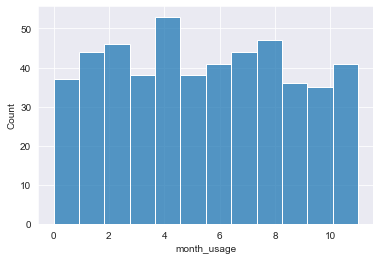

In [141]:
sns.histplot(
    data=user_profit['month_usage'],
    bins=(1+user_profit['month_usage'].max())
)

#### количество сделанных звонков и израсходованных минут разговора по месяцам;

In [170]:


def count_monthly(number_of_month, u_id, u_reg_date):
    end_month = u_reg_date + pd.DateOffset(months=number_of_month)
    start_month = end_month - pd.DateOffset(months=1)
    calls_gt_zero = calls_df['duration'] != 0

    pick_user_month = (
        (calls_df['user_id'] == u_id)
        & (calls_df['call_date'] < end_month)
        & (calls_df['call_date'] >= start_month)
    )

    count_of_calls = (calls_df.loc[
            pick_user_month
            & calls_gt_zero
            , 'duration'
        ].count()
    )

    count_of_minutes = (calls_df.loc[
            pick_user_month
            & calls_gt_zero
            , 'duration'
        ].sum()
    )

    count_of_messages = (messages_df.loc[
            pick_user_month
            , 'id'
        ].count()
    )

    count_of_mb = (internet_df.loc[
            pick_user_month
            , 'mb_used'
        ].sum()
    )

    count_of_session = (internet_df.loc[
            pick_user_month
            , 'id'
        ].count()
    )
    return count_of_calls,\
           count_of_minutes,\
           count_of_messages,\
           count_of_mb,\
           count_of_session



In [171]:


def spend_monthly(u_id):
    picked_user = user_profit['user_id'] == u_id

    u_month_usage = user_profit.loc[
            picked_user
            , 'month_usage'
        ].item()

    u_reg_date = users_df.loc[
            picked_user
            , 'reg_date'
        ].item()

    months_range = pd.Series(
            data=range(1, u_month_usage + 1),
            name='month',
            dtype='uint8',
        )

    count_of_calls_monthly\
        , count_of_minutes_monthly\
        , count_of_messages_monthly\
        , count_of_mb_monthly\
        , count_of_session_monthly  = zip(
        * months_range.apply(
            count_monthly,
            u_id=u_id,
            u_reg_date=u_reg_date
        )
    )

    return count_of_calls_monthly,\
           count_of_minutes_monthly,\
           count_of_messages_monthly,\
           count_of_mb_monthly,\
           count_of_session_monthly



In [172]:
use_gt_month = user_profit['month_usage'] > 0

In [173]:
user_profit.loc[use_gt_month
    ,'calls_monthly'
], user_profit.loc[use_gt_month
    ,'minutes_monthly'
], user_profit.loc[use_gt_month
    ,'messages_monthly'
], user_profit.loc[use_gt_month
    ,'mb_monthly'
], user_profit.loc[use_gt_month
    ,'session_monthly'
] =  zip(
    * user_profit.loc[use_gt_month
        , 'user_id'
    ].apply(spend_monthly)
)

/Users/bionic/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [174]:
display(
    user_profit.sample(5)
)

,user_id,month_usage,calls_monthly,minutes_monthly,messages_monthly,mb_monthly,session_monthly
424,1424,6,"(2, 3, 8, 4, 4, 7)","(13.0, 28.0, 65.0, 21.0, 20.0, 87.0)","(0, 0, 0, 0, 0, 0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0, 0, 0, 0, 0, 0)"
416,1416,4,"(111, 83, 118, 129)","(940.0, 727.0, 994.0, 1056.0)","(0, 0, 0, 0)","(0.0, 0.0, 0.0, 0.0)","(0, 0, 0, 0)"
182,1182,2,"(22, 31)","(215.0, 268.0)","(29, 34)","(10980.740000000003, 12179.13)","(29, 34)"
332,1332,7,"(64, 50, 53, 43, 51, 56, 52)","(564.0, 468.0, 456.0, 404.0, 453.0, 567.0, 539.0)","(0, 0, 0, 0, 0, 0, 0)","(24224.96, 18376.799999999996, 15073.730000000...","(78, 60, 65, 56, 60, 72, 66)"
195,1195,2,"(55, 56)","(461.0, 458.0)","(73, 73)","(23816.14, 20836.72)","(73, 73)"


In [175]:
display(
    tariffs_df
)


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [176]:
name_smart = tariffs_df.loc[0, 'tariff_name']
only_smart = tariffs_df['tariff_name'] == name_smart

sm_sms_pckg = tariffs_df.loc[only_smart
    , 'messages_included'].item()

sm_mb_pckg = tariffs_df.loc[only_smart
    , 'mb_per_month_included'].item()

sm_min_pckg = tariffs_df.loc[only_smart
    , 'minutes_included'].item()

sm_fee_pckg = tariffs_df.loc[only_smart
    , 'rub_monthly_fee'].item()

sm_per_gb_fee = tariffs_df.loc[only_smart
    , 'rub_per_gb'].item()

sm_per_sms_fee = tariffs_df.loc[only_smart
    , 'rub_per_message'].item()

sm_per_min_fee = tariffs_df.loc[only_smart
    , 'rub_per_minute'].item()

In [177]:
name_ultra = tariffs_df.loc[1, 'tariff_name']
only_ultra = tariffs_df['tariff_name'] == name_ultra

ul_sms_pckg = tariffs_df.loc[only_ultra
    , 'messages_included'].item()

ul_mb_pckg = tariffs_df.loc[only_ultra
    , 'mb_per_month_included'].item()

ul_min_pckg = tariffs_df.loc[only_ultra
    , 'minutes_included'].item()

ul_fee_pckg = tariffs_df.loc[only_ultra
    , 'rub_monthly_fee'].item()

ul_per_gb_fee = tariffs_df.loc[only_ultra
    , 'rub_per_gb'].item()

ul_per_sms_fee = tariffs_df.loc[only_ultra
    , 'rub_per_message'].item()

ul_per_min_fee = tariffs_df.loc[only_ultra
    , 'rub_per_minute'].item()

In [178]:
display(
    users_df.sample(2)
)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
479,1479,40,NaT,Хабаровск,Игорь,Богданов,2018-07-03,False
36,1036,47,NaT,Санкт-Петербург,Анжелика,Андропова,2018-07-14,False


In [179]:
display(
    user_profit.sample(2)
)

,user_id,month_usage,calls_monthly,minutes_monthly,messages_monthly,mb_monthly,session_monthly
411,1411,5,"(66, 69, 55, 66, 78)","(636.0, 611.0, 513.0, 578.0, 691.0)","(0, 0, 0, 0, 0)","(0.0, 0.0, 0.0, 0.0, 0.0)","(0, 0, 0, 0, 0)"
123,1123,9,"(57, 63, 55, 60, 71, 80, 62, 59, 82)","(528.0, 570.0, 472.0, 594.0, 677.0, 695.0, 548...","(77, 76, 74, 76, 86, 107, 76, 79, 101)","(26490.53, 25631.390000000003, 26427.06, 26351...","(77, 76, 74, 76, 86, 107, 76, 79, 101)"


In [201]:


def calc_profit_smart(monthly_profit):
    extra_min_monthly = pd.Series(
            monthly_profit.loc['minutes_monthly']
        ).apply(
            lambda mn: (mn - sm_min_pckg)
                if (mn - sm_min_pckg) > 0 else 0
        )

    extra_sms_monthly = pd.Series(
            monthly_profit.loc['messages_monthly']
        ).apply(
            lambda sm: (sm - sm_sms_pckg)
                if (sm - sm_sms_pckg) > 0 else 0
        )

    extra_gb_monthly = pd.Series(
            monthly_profit.loc['mb_monthly']
        ).apply(
            lambda mb: np.ceil((mb - sm_mb_pckg) / mb_in_gb)
                if (mb - sm_mb_pckg) > 0 else 0
        )

    extra_fee_min_monthly = extra_min_monthly * sm_per_min_fee
    extra_fee_sms_monthly = extra_sms_monthly * sm_per_sms_fee
    extra_fee_gb_monthly = extra_gb_monthly * sm_per_gb_fee

    total_extra_fee_monthly = pd.Series(
        np.sum(
            [extra_fee_min_monthly,
            extra_fee_sms_monthly,
            extra_fee_gb_monthly]
            , axis=0
        )
    )

    total_fee_monthly = total_extra_fee_monthly + sm_fee_pckg

    return np.array(object=extra_fee_min_monthly, dtype=object),\
           np.array(object=extra_fee_sms_monthly, dtype=object),\
           np.array(object=extra_fee_gb_monthly, dtype=object),\
           np.array(object=total_extra_fee_monthly, dtype=object),\
           np.array(object=total_fee_monthly, dtype=object)



In [202]:


def calc_profit_ultra(monthly_profit):
    extra_min_monthly = pd.Series(
            monthly_profit.loc['minutes_monthly']
        ).apply(
            lambda mn: (mn - ul_min_pckg)
                if (mn - ul_min_pckg) > 0 else 0
        )

    extra_sms_monthly = pd.Series(
            monthly_profit.loc['messages_monthly']
        ).apply(
            lambda sm: (sm - ul_sms_pckg)
                if (sm - ul_sms_pckg) > 0 else 0
        )

    extra_gb_monthly = pd.Series(
            monthly_profit.loc['mb_monthly']
        ).apply(
            lambda mb: np.ceil((mb - ul_mb_pckg) / mb_in_gb)
                if (mb - ul_mb_pckg) > 0 else 0
        )

    extra_fee_min_monthly = extra_min_monthly * ul_per_min_fee
    extra_fee_sms_monthly = extra_sms_monthly * ul_per_sms_fee
    extra_fee_gb_monthly = extra_gb_monthly * ul_per_gb_fee

    total_extra_fee_monthly = pd.Series(
        np.sum(
            [extra_fee_min_monthly,
            extra_fee_sms_monthly,
            extra_fee_gb_monthly]
            , axis=0
        )
    )

    total_fee_monthly = total_extra_fee_monthly + ul_fee_pckg
    
    return np.array(object=extra_fee_min_monthly, dtype=object),\
           np.array(object=extra_fee_sms_monthly, dtype=object),\
           np.array(object=extra_fee_gb_monthly, dtype=object),\
           np.array(object=total_extra_fee_monthly, dtype=object),\
           np.array(object=total_fee_monthly, dtype=object)



##### users of «smart»

In [203]:
users_of_smart = users_df['tariff'] == False

In [204]:
users_of_smart_gt_month = users_of_smart & use_gt_month

In [205]:
user_profit.loc[users_of_smart_gt_month
    , 'extra_fee_min_monthly'
], user_profit.loc[users_of_smart_gt_month
    , 'extra_fee_sms_monthly'
], user_profit.loc[users_of_smart_gt_month
    , 'extra_fee_gb_monthly'
], user_profit.loc[users_of_smart_gt_month
    , 'total_extra_fee_monthly'
], user_profit.loc[users_of_smart_gt_month
, 'total_fee_monthly'
] = zip(
    * user_profit.loc[users_of_smart_gt_month
        , ['minutes_monthly',
           'messages_monthly',
           'mb_monthly']
    ].apply(calc_profit_smart, axis=1)
)

/Users/bionic/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/Users/bionic/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/missing.py:531: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.array(val, copy=False)


##### users of «ultra»

In [206]:
users_of_ultra = users_df['tariff'] == True

In [207]:
users_of_ultra_gt_month = users_of_ultra & use_gt_month

In [208]:
user_profit.loc[users_of_ultra_gt_month
, 'extra_fee_min_monthly'
], user_profit.loc[users_of_ultra_gt_month
, 'extra_fee_sms_monthly'
], user_profit.loc[users_of_ultra_gt_month
, 'extra_fee_gb_monthly'
], user_profit.loc[users_of_ultra_gt_month
, 'total_extra_fee_monthly'
], user_profit.loc[users_of_ultra_gt_month
, 'total_fee_monthly'
] = zip(
    * user_profit.loc[users_of_ultra_gt_month
    , ['minutes_monthly',
       'messages_monthly',
       'mb_monthly']
    ].apply(calc_profit_smart, axis=1)
)

#### количество отправленных сообщений по месяцам;

In [209]:
display(
    user_profit.sample(7)
)

,user_id,month_usage,calls_monthly,minutes_monthly,messages_monthly,mb_monthly,session_monthly,extra_fee_min_monthly,extra_fee_sms_monthly,extra_fee_gb_monthly,total_extra_fee_monthly,total_fee_monthly
150,1150,4,"(44, 43, 40, 47)","(457.0, 389.0, 351.0, 462.0)","(57, 50, 51, 55)","(24306.37, 27087.789999999997, 24161.710000000...","(57, 50, 51, 55)","[0, 0, 0, 0]","[21, 0, 3, 15]","[1800.0, 2400.0, 1800.0, 1200.0]","[1821.0, 2400.0, 1803.0, 1215.0]","[2371.0, 2950.0, 2353.0, 1765.0]"
256,1256,3,"(72, 54, 70)","(646.0, 572.0, 563.0)","(89, 72, 85)","(27273.839999999997, 25762.65, 24961.449999999...","(89, 72, 85)","[438.0, 216.0, 189.0]","[117, 66, 105]","[2400.0, 2200.0, 2000.0]","[2955.0, 2482.0, 2294.0]","[3505.0, 3032.0, 2844.0]"
112,1112,3,"(54, 57, 58)","(536.0, 520.0, 455.0)","(75, 72, 76)","(23792.079999999998, 21733.21, 27023.97)","(75, 72, 76)","[108.0, 60.0, 0.0]","[75, 66, 78]","[1800.0, 1400.0, 2400.0]","[1983.0, 1526.0, 2478.0]","[2533.0, 2076.0, 3028.0]"
5,1005,11,"(63, 52, 78, 59, 70, 61, 66, 57, 75, 66, 59)","(519.0, 477.0, 763.0, 538.0, 635.0, 584.0, 608...","(80, 64, 104, 70, 80, 77, 72, 67, 92, 85, 74)","(23920.489999999998, 17581.37, 35444.76, 20573...","(80, 64, 104, 70, 80, 77, 72, 67, 92, 85, 74)","[57.0, 0.0, 789.0, 114.0, 405.0, 252.0, 324.0,...","[90, 42, 162, 60, 90, 81, 66, 51, 126, 105, 72]","[1800.0, 600.0, 4000.0, 1200.0, 2600.0, 2000.0...","[1947.0, 642.0, 4951.0, 1374.0, 3095.0, 2333.0...","[2497.0, 1192.0, 5501.0, 1924.0, 3645.0, 2883...."
40,1040,6,"(28, 45, 35, 19, 38, 48)","(235.0, 414.0, 365.0, 196.0, 316.0, 413.0)","(35, 53, 42, 24, 46, 55)","(10653.859999999999, 15059.460000000001, 15950...","(35, 53, 42, 24, 46, 55)","[0, 0, 0, 0, 0, 0]","[0, 9, 0, 0, 0, 15]","[0.0, 0.0, 200.0, 0.0, 0.0, 800.0]","[0.0, 9.0, 200.0, 0.0, 0.0, 815.0]","[550.0, 559.0, 750.0, 550.0, 550.0, 1365.0]"
491,1491,8,"(59, 64, 64, 65, 54, 70, 61, 70)","(486.0, 543.0, 558.0, 630.0, 481.0, 624.0, 543...","(0, 0, 0, 0, 0, 0, 0, 0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0, 0, 0, 0, 0, 0, 0, 0)","[0.0, 129.0, 174.0, 390.0, 0.0, 372.0, 129.0, ...","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.0, 129.0, 174.0, 390.0, 0.0, 372.0, 129.0, ...","[550.0, 679.0, 724.0, 940.0, 550.0, 922.0, 679..."
437,1437,4,"(33, 28, 33, 29)","(330.0, 203.0, 268.0, 241.0)","(0, 0, 0, 0)","(0.0, 0.0, 0.0, 0.0)","(0, 0, 0, 0)","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[550, 550, 550, 550]"


#### объем израсходованного интернет-трафика по месяцам;

#### помесячную выручку с каждого пользователя

(вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

<hr>

## Шаг 3. Анализ данных

### Описание поведения клиентов оператора, исходя из выборки.

#### Сколько минут разговора требуется пользователям каждого тарифа в месяц?

###### users of «smart»

<AxesSubplot:ylabel='Count'>

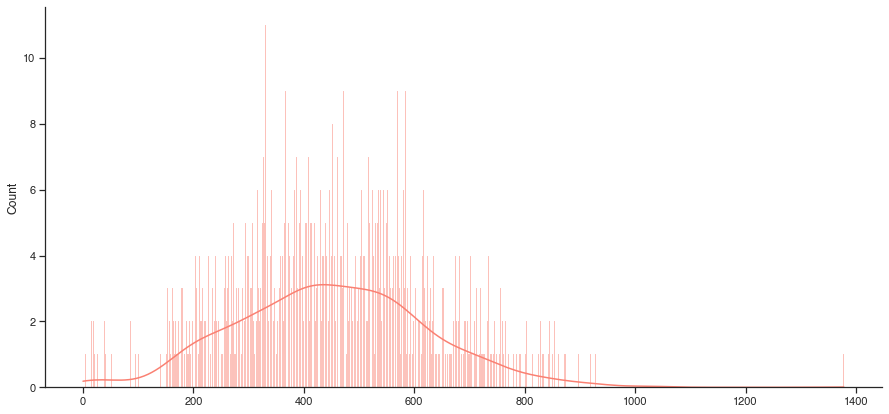

In [374]:
sm_min_arr = []

user_profit.loc[users_of_smart_gt_month
    , 'minutes_monthly'
    ].apply(
        lambda ma: sm_min_arr.extend(ma)
    )

# setting the dimensions of the plot
_, sm = plt.subplots(figsize=(15, 7))
sns.histplot(sm_min_arr,
    bins=int(len(sm_min_arr)),
    color='salmon',
    kde=True,
    ax=sm,
 )

In [375]:
sm_min_ser = pd.Series(sm_min_arr, dtype=int)

In [376]:
display(
    sm_min_ser.describe()
)

count    1876.000000
mean      450.265458
std       174.036091
min         0.000000
25%       330.000000
50%       449.000000
75%       563.000000
max      1378.000000
dtype: float64

In [377]:
sm_dispersion = np.var(sm_min_ser, ddof=1)

In [378]:
sm_standard_deviation = np.std(sm_min_ser, ddof=1)

In [379]:
print('«smart» dispersion',
    round(sm_dispersion, 2)
)
print('«smart» standard deviation',
      round(sm_standard_deviation, 2)
      )

«smart» dispersion 30288.56
«smart» standard deviation 174.04


###### users of «ultra»

<AxesSubplot:ylabel='Count'>

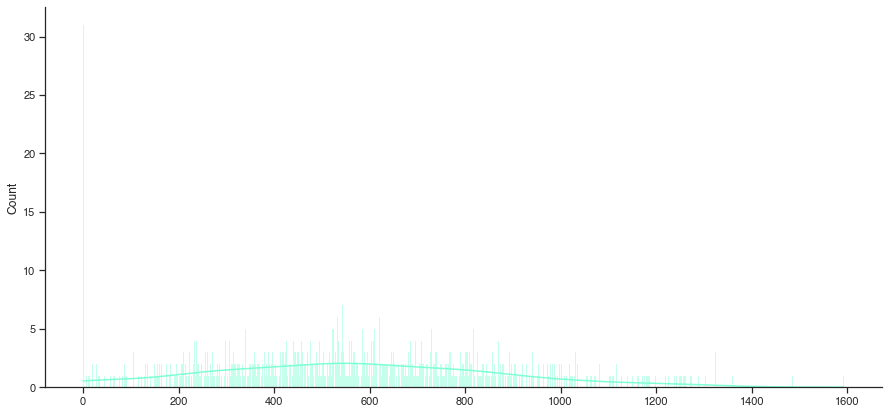

In [380]:
ul_min_arr = []

user_profit.loc[users_of_ultra_gt_month
    , 'minutes_monthly'
    ].apply(
        lambda ma: ul_min_arr.extend(ma)
    )

# setting the dimensions of the plot
_, ul = plt.subplots(figsize=(15, 7))
sns.histplot(ul_min_arr,
    bins=int(len(ul_min_arr)),
    color='aquamarine',
    kde=True,
    ax=ul,
 )

In [381]:
ul_min_ser = pd.Series(ul_min_arr, dtype=int)

In [382]:
display(
    ul_min_ser.describe()
)

count     831.000000
mean      568.814681
std       304.278268
min         0.000000
25%       349.500000
50%       556.000000
75%       771.000000
max      1593.000000
dtype: float64

In [383]:
ul_dispersion = np.var(ul_min_ser, ddof=1)

In [384]:
ul_standard_deviation = np.std(ul_min_ser, ddof=1)

In [385]:
print('«ultra» dispersion',
    round(ul_dispersion, 2)
)
print('«ultra» standard deviation',
    round(ul_standard_deviation, 2)
)

«ultra» dispersion 92585.26
«ultra» standard deviation 304.28


 ##### Среднее количество минут, дисперсия и стандартное отклонение.

##### Гистограммы минут разговора.

##### Описание распределений минут разговора.

<hr>

#### Сколько сообщений требуется пользователям каждого тарифа в месяц?

###### users of «smart»

In [386]:
sm_sms_arr = []

user_profit.loc[users_of_smart_gt_month
        , 'messages_monthly'
    ].apply(
        lambda sms: sm_sms_arr.extend(sms)
)

sm_sms_monthly = pd.Series(data=sm_sms_arr, dtype=int)

###### users of «ultra»

In [387]:
ul_sms_arr = []

user_profit.loc[users_of_ultra_gt_month
        , 'messages_monthly'
    ].apply(
        lambda sms: ul_sms_arr.extend(sms)
)

ul_sms_monthly = pd.Series(data=ul_sms_arr, dtype=int)

##### Гистограммы сообщений.

###### users of «smart»

<AxesSubplot:ylabel='Count'>

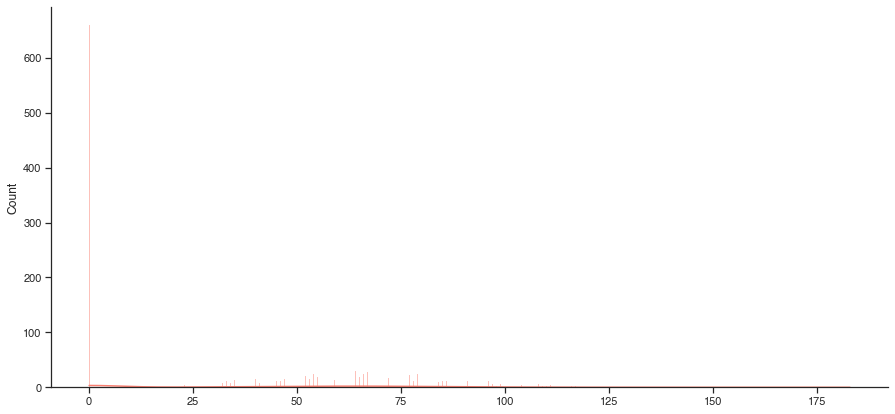

In [388]:
_, sm = plt.subplots(figsize=(15, 7))
sns.histplot(sm_sms_arr,
             bins=int(len(sm_sms_arr)),
             color='salmon',
             kde=True,
             ax=sm,
             )

<AxesSubplot:ylabel='Count'>

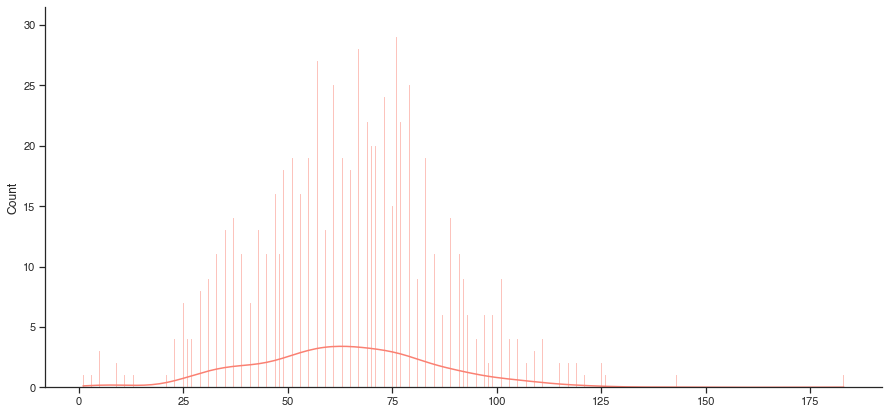

In [389]:
sm_sms_wo_zero = list(sm_sms_monthly.loc[sm_sms_monthly != 0])

_, sm = plt.subplots(figsize=(15, 7))
sns.histplot(sm_sms_wo_zero,
             bins=int(len(sm_sms_wo_zero)),
             color='salmon',
             kde=True,
             ax=sm,
             )

###### users of «ultra»

<AxesSubplot:ylabel='Count'>

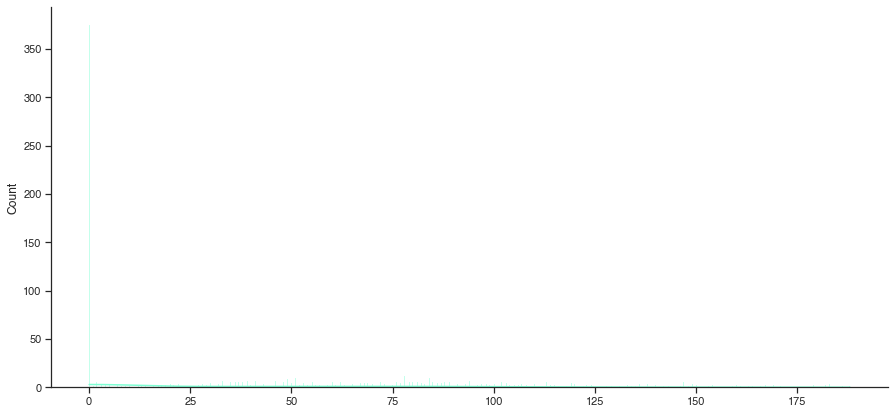

In [390]:
_, ul = plt.subplots(figsize=(15, 7))
sns.histplot(ul_sms_arr,
    bins=int(len(ul_sms_arr)),
    color='aquamarine',
    kde=True,
    ax=ul,
    # log_scale=(False, True)
)

<AxesSubplot:ylabel='Count'>

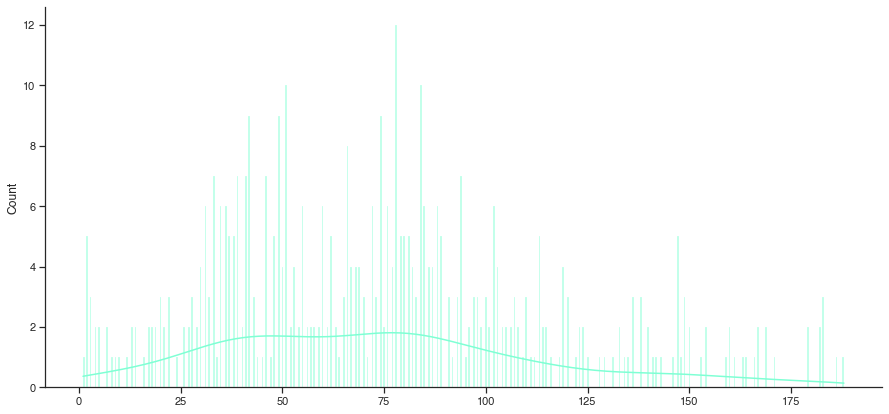

In [391]:
ul_sms_wo_zero = list(ul_sms_monthly.loc[ul_sms_monthly != 0])

_, ul = plt.subplots(figsize=(15, 7))
sns.histplot(ul_sms_wo_zero,
    bins=int(len(ul_sms_wo_zero)),
    color='aquamarine',
    kde=True,
    ax=ul,
)

 ##### Среднее количество сообщений, дисперсия и стандартное отклонение.

###### users of «smart»

In [392]:
sm_sms_dispersion = np.var(sm_sms_arr, ddof=1)

In [393]:
sm_sms_standard_deviation = np.std(sm_sms_arr, ddof=1)

In [426]:
print('«smart» sms', end='\n\n')
print('var'
    , round(sm_sms_dispersion, 3)
    , sep='\t\t'
)
print('std'
    , round(sm_sms_standard_deviation, 3)
    , sep='\t\t'
    , end='\n\n'
)
print(sm_sms_monthly.describe())

«smart» sms

var		1241.641
std		35.237

count    1876.000000
mean       41.278785
std        35.236929
min         0.000000
25%         0.000000
50%        48.000000
75%        70.000000
max       183.000000
dtype: float64


###### users of «ultra»

In [395]:
ul_sms_dispersion = np.var(ul_sms_arr, ddof=1)

In [396]:
ul_sms_standard_deviation = np.std(ul_sms_arr, ddof=1)

In [397]:
print('«ultra» sms', end='\n\n')
print('var'
    , round(ul_sms_dispersion, 3)
    , sep='\t\t'
)
print('std'
    , round(ul_sms_standard_deviation, 3)
    , sep='\t\t'
    , end='\n\n'
)
print(ul_sms_monthly.describe())

«ultra» sms dispersion

var		2299.4
std		47.952

count    831.000000
mean      40.936221
std       47.952055
min        0.000000
25%        0.000000
50%       26.000000
75%       76.500000
max      188.000000
dtype: float64


##### Описание распределений сообщений.

###### users of «smart»

###### users of «ultra»

<hr>

#### Какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

###### users of «smart»

In [420]:
sm_gb_arr = []

user_profit.loc[users_of_smart_gt_month
        , 'mb_monthly'
    ].apply(
        lambda mb: sm_gb_arr.extend(
            np.round(
                np.array(mb) / mb_in_gb
            )
        )
)

sm_gb_monthly = pd.Series(data=sm_gb_arr, dtype=int)

###### users of «ultra»

In [421]:
ul_gb_arr = []

user_profit.loc[users_of_ultra_gt_month
        , 'mb_monthly'
    ].apply(
        lambda mb: ul_gb_arr.extend(
            np.round(
                np.array(mb) / mb_in_gb
            )
        )
)

ul_gb_monthly = pd.Series(data=ul_gb_arr, dtype=int)

##### Гистограммы интернет-трафика.

###### users of «smart»

<AxesSubplot:ylabel='Count'>

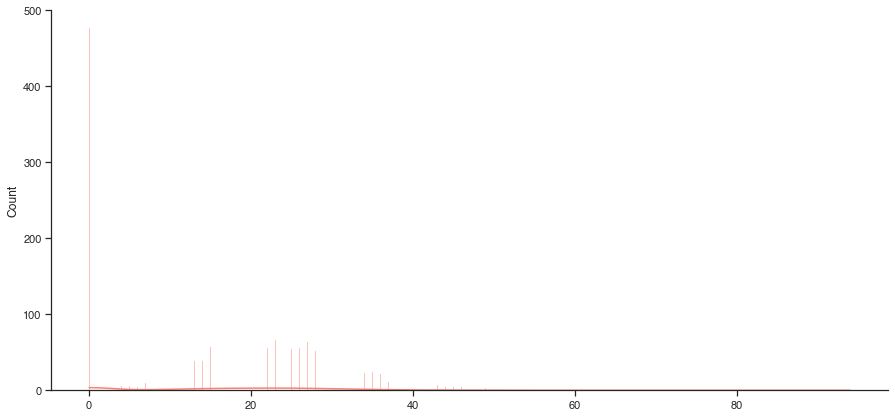

In [422]:
_, sm = plt.subplots(figsize=(15, 7))
sns.histplot(sm_gb_arr,
             bins=int(len(sm_gb_arr)),
             color='salmon',
             kde=True,
             ax=sm,
             )

<AxesSubplot:ylabel='Count'>

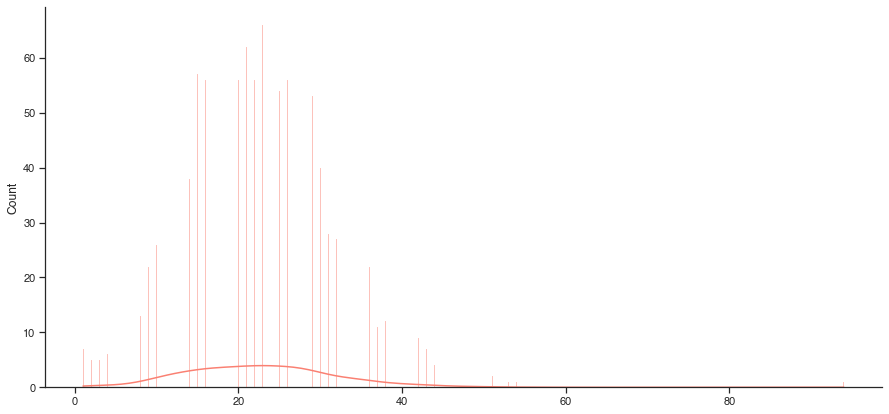

In [423]:
sm_gb_wo_zero = list(sm_gb_monthly.loc[sm_gb_monthly != 0])


_, sm = plt.subplots(figsize=(15, 7))
sns.histplot(sm_gb_wo_zero,
             bins=int(len(sm_gb_wo_zero)),
             color='salmon',
             kde=True,
             ax=sm,
             )

###### users of «ultra»

<AxesSubplot:ylabel='Count'>

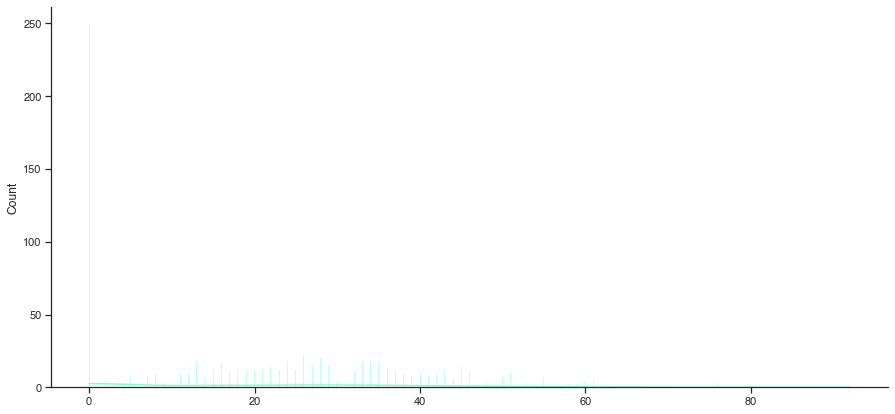

In [424]:
_, ul = plt.subplots(figsize=(15, 7))
sns.histplot(ul_gb_arr,
    bins=int(len(ul_gb_arr)),
    color='aquamarine',
    kde=True,
    ax=ul,
)

<AxesSubplot:ylabel='Count'>

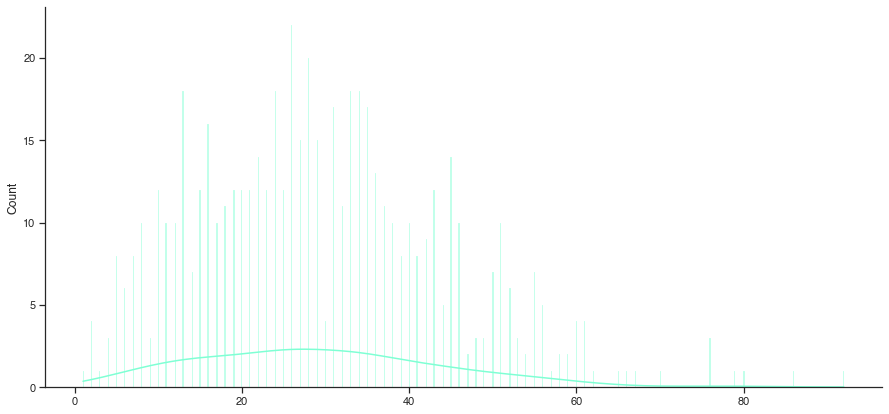

In [427]:
ul_gb_wo_zero = list(ul_gb_monthly.loc[ul_gb_monthly != 0])

_, ul = plt.subplots(figsize=(15, 7))
sns.histplot(ul_gb_wo_zero,
    bins=int(len(ul_gb_wo_zero)),
    color='aquamarine',
    kde=True,
    ax=ul,
)

 Посчитайте среднее количество интернет-трафика, дисперсию и стандартное отклонение.

###### users of «smart»

In [411]:
sm_gb_dispersion = np.var(sm_gb_arr, ddof=1)

In [412]:
sm_gb_standard_deviation = np.std(sm_gb_arr, ddof=1)

In [417]:
print('«smart» gb', end='\n\n')
print('var'
      , round(sm_gb_dispersion, 3)
      , sep='\t\t'
      )
print('std'
      , round(sm_gb_standard_deviation, 3)
      , sep='\t\t'
      , end='\n\n'
      )
print(sm_gb_monthly.describe())

«smart» gb

var		168804443.692
std		12992.476

count     1876.000000
mean     17334.728678
std      12992.476426
min          0.000000
25%          0.000000
50%      18626.500000
75%      26885.250000
max      95902.000000
dtype: float64


###### users of «ultra»

In [395]:
ul_gb_dispersion = np.var(ul_gb_arr, ddof=1)

In [396]:
ul_gb_standard_deviation = np.std(ul_gb_arr, ddof=1)

In [425]:
print('«ultra» gb', end='\n\n')
print('var'
    , round(ul_sms_dispersion, 3)
    , sep='\t\t'
)
print('std'
    , round(ul_sms_standard_deviation, 3)
    , sep='\t\t'
    , end='\n\n'
)
print(ul_sms_monthly.describe())

«ultra» gb

var		2299.4
std		47.952

count    831.000000
mean      40.936221
std       47.952055
min        0.000000
25%        0.000000
50%       26.000000
75%       76.500000
max      188.000000
dtype: float64


##### Описание распределений интернет-трафика.

<hr>

## Шаг 4. Проверьте гипотезы

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Поясните:
как вы формулировали нулевую и альтернативную гипотезы;
какой критерий использовали для проверки гипотез и почему.

<hr>

## Шаг 5. Общий вывод

Описание данных
Таблица users (информация о пользователях):
user_id — уникальный идентификатор пользователя
first_name — имя пользователя
last_name — фамилия пользователя
age — возраст пользователя (годы)
reg_date — дата подключения тарифа (день, месяц, год)
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
city — город проживания пользователя
tariff — название тарифного плана
Таблица calls (информация о звонках):
id — уникальный номер звонка
call_date — дата звонка
duration — длительность звонка в минутах
user_id — идентификатор пользователя, сделавшего звонок
Таблица messages (информация о сообщениях):
id — уникальный номер сообщения
message_date — дата сообщения
user_id — идентификатор пользователя, отправившего сообщение
Таблица internet (информация об интернет-сессиях):
id — уникальный номер сессии
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
session_date — дата интернет-сессии
user_id — идентификатор пользователя
Таблица tariffs (информация о тарифах):
tariff_name — название тарифа
rub_monthly_fee — ежемесячная абонентская плата в рублях
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
messages_included — количество сообщений в месяц, включённых в абонентскую плату
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
rub_per_message — стоимость отправки сообщения сверх тарифного пакета
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)